In [21]:
import cv2
import mediapipe as mp

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.75,
    min_tracking_confidence=0.75,
    max_num_hands=2
)

cap = cv2.VideoCapture(0)

while True:
    success, img = cap.read()
    if not success:
        print("Failed to grab frame")
        break

    # mirror image for webcam-like view
    img = cv2.flip(img, 1)

    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(imgRGB)

    if results.multi_hand_landmarks:
        # if two hands detected, show 'Both Hands'
        if len(results.multi_handedness) == 2:
            cv2.putText(img, 'Both Hands', (250, 50),
                        cv2.FONT_HERSHEY_COMPLEX, 0.9, (0, 255, 0), 2)
        # otherwise iterate and get label for each detected hand
        # note: the order of multi_hand_landmarks and multi_handedness is linked,
        # so use the same index for both lists.
        for idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
            # get handedness label directly from the proto object
            # classification is a repeated field; [0] holds the top label
            handedness_proto = results.multi_handedness[idx]
            label = handedness_proto.classification[0].label  # 'Left' or 'Right'

            # choose x position based on label (or use bounding box center if you prefer)
            if label == 'Left':
                x_pos = 20
            else:
                x_pos = img.shape[1] - 140  # near right edge

            cv2.putText(img, f'{label} Hand', (x_pos, 50),
                        cv2.FONT_HERSHEY_COMPLEX, 0.9, (0, 255, 0), 2)

            # Optionally draw the landmarks
            mp.solutions.drawing_utils.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    cv2.imshow('Image', img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [3]:
!pip install pandas matplotlib mediapipe opencv-python

Detected 1 hand. Landmark table (normalized coords and pixel coords):



,name,x_norm,y_norm,z_norm,x_px,y_px
index,,,,,,
0,WRIST,0.411046,0.965201,4.577072e-07,263,463
1,THUMB_CMC,0.502990,0.931349,-4.968214e-02,322,447
2,THUMB_MCP,0.582541,0.838658,-6.981130e-02,373,403
3,THUMB_IP,0.637471,0.751021,-8.573711e-02,408,360
4,THUMB_TIP,0.688826,0.688781,-1.020165e-01,441,331
5,INDEX_MCP,0.522086,0.645360,-4.496658e-02,334,310
6,INDEX_PIP,0.544101,0.513947,-7.401592e-02,348,247
7,INDEX_DIP,0.557232,0.435067,-9.803444e-02,357,209
8,INDEX_TIP,0.568085,0.363314,-1.172267e-01,364,174



Num landmarks: 21 (should be 21).  Shape: (21, 3)


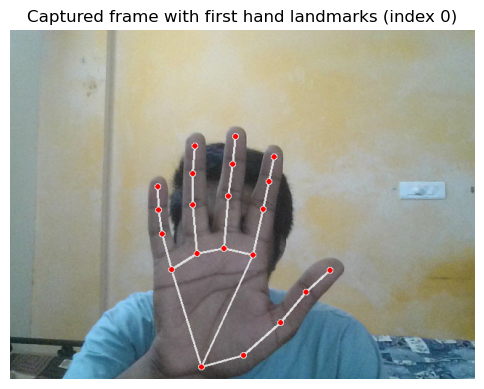

In [24]:
# Paste this entire block into a Jupyter cell and run it.
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Setup ---
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.75,
    min_tracking_confidence=0.75,
    max_num_hands=2
)

# Friendly mapping of landmark index -> anatomical name
LANDMARK_NAMES = {
    0: "WRIST",
    1: "THUMB_CMC",
    2: "THUMB_MCP",
    3: "THUMB_IP",
    4: "THUMB_TIP",
    5: "INDEX_MCP",
    6: "INDEX_PIP",
    7: "INDEX_DIP",
    8: "INDEX_TIP",
    9: "MIDDLE_MCP",
    10: "MIDDLE_PIP",
    11: "MIDDLE_DIP",
    12: "MIDDLE_TIP",
    13: "RING_MCP",
    14: "RING_PIP",
    15: "RING_DIP",
    16: "RING_TIP",
    17: "PINKY_MCP",
    18: "PINKY_PIP",
    19: "PINKY_DIP",
    20: "PINKY_TIP",
}

# --- Capture one frame from webcam ---
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()

if not ret:
    raise RuntimeError("Unable to read from the webcam (device 0). Make sure the camera is connected.")

# Mirror image for a webcam-like view
frame = cv2.flip(frame, 1)
img_h, img_w = frame.shape[:2]

# Convert to RGB for MediaPipe
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# --- Process with MediaPipe Hands ---
results = hands.process(frame_rgb)

if results.multi_hand_landmarks and len(results.multi_hand_landmarks) > 0:
    # We'll take the first detected hand (index 0)
    hand_landmarks = results.multi_hand_landmarks[0]

    # Build a table of landmark values
    rows = []
    for idx, lm in enumerate(hand_landmarks.landmark):
        x_norm = lm.x
        y_norm = lm.y
        z_norm = lm.z
        x_px = int(round(x_norm * img_w))
        y_px = int(round(y_norm * img_h))
        rows.append({
            "index": idx,
            "name": LANDMARK_NAMES.get(idx, f"LM_{idx}"),
            "x_norm": float(x_norm),
            "y_norm": float(y_norm),
            "z_norm": float(z_norm),
            "x_px": int(x_px),
            "y_px": int(y_px)
        })

    df = pd.DataFrame(rows)
    df = df.set_index("index")
    # Print summary information
    print("Detected 1 hand. Landmark table (normalized coords and pixel coords):\n")
    display(df)   # shows a nice table in Jupyter

    # Also print small summary / shapes
    coords_np = np.array([[r["x_norm"], r["y_norm"], r["z_norm"]] for r in rows])
    print(f"\nNum landmarks: {coords_np.shape[0]} (should be 21).  Shape: {coords_np.shape}")

    # Draw landmarks on the image for visualization
    annotated = frame.copy()
    mp_drawing.draw_landmarks(annotated, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Show the annotated image inline
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Captured frame with first hand landmarks (index 0)")
    plt.show()

else:
    print("No hand detected in the captured frame. Try moving your hand in front of the webcam and re-run the cell.")

# Clean up MediaPipe resources
hands.close()

✅ Detected one hand.

📏 Distance between Thumb Tip (LM_4) and Index Tip (LM_8):
   → Normalized distance: 0.2828
   → Pixel distance: 143.27 pixels



,name,x_norm,y_norm,z_norm,x_px,y_px
index,,,,,,
0,WRIST,0.369944,0.769535,6.459198e-07,236,369
1,THUMB_CMC,0.442437,0.736813,-4.244831e-02,283,353
2,THUMB_MCP,0.498190,0.650492,-6.060640e-02,318,312
3,THUMB_IP,0.538301,0.573397,-7.492840e-02,344,275
4,THUMB_TIP,0.581374,0.518379,-8.886009e-02,372,248
5,INDEX_MCP,0.443164,0.488571,-2.734028e-02,283,234
6,INDEX_PIP,0.457389,0.383619,-4.980547e-02,292,184
7,INDEX_DIP,0.466174,0.316336,-7.124686e-02,298,151
8,INDEX_TIP,0.472314,0.257431,-8.790009e-02,302,123


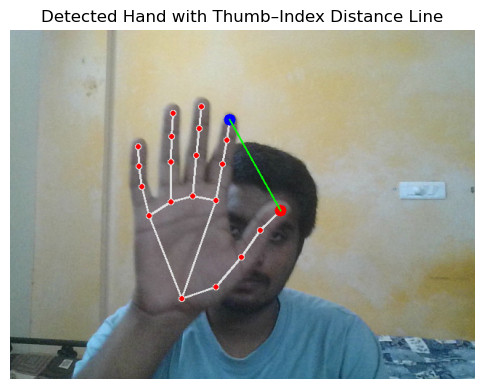

In [25]:
# --- Auto-install required libraries (run only if missing) ---
try:
    import mediapipe as mp
    import cv2
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    !pip install mediapipe opencv-python pandas matplotlib
    import mediapipe as mp
    import cv2
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

# --- Setup ---
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    max_num_hands=2
)

# Landmark names for clarity
LANDMARK_NAMES = {
    0: "WRIST",
    1: "THUMB_CMC",
    2: "THUMB_MCP",
    3: "THUMB_IP",
    4: "THUMB_TIP",
    5: "INDEX_MCP",
    6: "INDEX_PIP",
    7: "INDEX_DIP",
    8: "INDEX_TIP",
    9: "MIDDLE_MCP",
    10: "MIDDLE_PIP",
    11: "MIDDLE_DIP",
    12: "MIDDLE_TIP",
    13: "RING_MCP",
    14: "RING_PIP",
    15: "RING_DIP",
    16: "RING_TIP",
    17: "PINKY_MCP",
    18: "PINKY_PIP",
    19: "PINKY_DIP",
    20: "PINKY_TIP",
}

# --- Capture one frame from webcam ---
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()

if not ret:
    raise RuntimeError("Unable to read from the webcam (device 0). Check camera connection.")

# Mirror for a natural webcam view
frame = cv2.flip(frame, 1)
img_h, img_w = frame.shape[:2]

# Convert BGR → RGB (MediaPipe expects RGB)
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# --- Run MediaPipe Hands ---
results = hands.process(frame_rgb)

if results.multi_hand_landmarks and len(results.multi_hand_landmarks) > 0:
    # Take first detected hand
    hand_landmarks = results.multi_hand_landmarks[0]

    # Store landmarks in a table
    rows = []
    for idx, lm in enumerate(hand_landmarks.landmark):
        x_norm, y_norm, z_norm = lm.x, lm.y, lm.z
        x_px, y_px = int(x_norm * img_w), int(y_norm * img_h)
        rows.append({
            "index": idx,
            "name": LANDMARK_NAMES.get(idx, f"LM_{idx}"),
            "x_norm": x_norm,
            "y_norm": y_norm,
            "z_norm": z_norm,
            "x_px": x_px,
            "y_px": y_px
        })

    df = pd.DataFrame(rows).set_index("index")

    # ---- Calculate Thumb–Index Tip Distance ----
    thumb_tip = df.loc[4]   # THUMB_TIP
    index_tip = df.loc[8]   # INDEX_TIP

    # Normalized distance
    norm_dist = np.sqrt(
        (thumb_tip["x_norm"] - index_tip["x_norm"])**2 +
        (thumb_tip["y_norm"] - index_tip["y_norm"])**2 +
        (thumb_tip["z_norm"] - index_tip["z_norm"])**2
    )

    # Pixel distance (2D)
    pixel_dist = np.sqrt(
        (thumb_tip["x_px"] - index_tip["x_px"])**2 +
        (thumb_tip["y_px"] - index_tip["y_px"])**2
    )

    print("✅ Detected one hand.\n")
    print(f"📏 Distance between Thumb Tip (LM_4) and Index Tip (LM_8):")
    print(f"   → Normalized distance: {norm_dist:.4f}")
    print(f"   → Pixel distance: {pixel_dist:.2f} pixels\n")

    # Display landmark table
    display(df)

    # Draw landmarks on image
    annotated = frame.copy()
    mp_drawing.draw_landmarks(annotated, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Highlight Thumb Tip and Index Tip points
    cv2.circle(annotated, (thumb_tip["x_px"], thumb_tip["y_px"]), 8, (0, 0, 255), -1)
    cv2.circle(annotated, (index_tip["x_px"], index_tip["y_px"]), 8, (255, 0, 0), -1)
    cv2.line(annotated,
             (thumb_tip["x_px"], thumb_tip["y_px"]),
             (index_tip["x_px"], index_tip["y_px"]),
             (0, 255, 0), 2)

    # Show annotated image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title("Detected Hand with Thumb–Index Distance Line")
    plt.axis("off")
    plt.show()

else:
    print("⚠️ No hand detected. Try showing your hand clearly to the webcam and re-run the cell.")

# Clean up
hands.close()

In [26]:
import time
import math
import cv2
import mediapipe as mp
import numpy as np

# --- Configuration ---
CAM_INDEX = 0                # webcam device index
PRINT_EVERY_N_FRAMES = 10    # console print frequency (reduce if you don't want too many prints)
PINCH_PIXEL_THRESHOLD = 40   # pixel threshold to consider "pinch" (tune for your camera/resolution)
PINCH_NORM_THRESHOLD = 0.03  # normalized distance threshold for pinch (tune if needed)

# --- Initialize MediaPipe Hands ---
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    max_num_hands=2
)

cap = cv2.VideoCapture(CAM_INDEX)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open camera index {CAM_INDEX}")

frame_count = 0
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to read frame from camera. Exiting.")
            break

        # Mirror frame for a natural webcam view
        frame = cv2.flip(frame, 1)
        img_h, img_w = frame.shape[:2]

        # Convert to RGB and process
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)

        # Default display values
        pixel_dist = None
        norm_dist = None
        pinch = False
        handedness_label = None

        if results.multi_hand_landmarks and len(results.multi_hand_landmarks) > 0:
            # Use the first detected hand (index 0)
            hand_landmarks = results.multi_hand_landmarks[0]

            # Get landmark 4 (thumb tip) and 8 (index tip)
            lm_thumb = hand_landmarks.landmark[4]
            lm_index = hand_landmarks.landmark[8]

            # Normalized euclidean distance (3D)
            dx_n = lm_thumb.x - lm_index.x
            dy_n = lm_thumb.y - lm_index.y
            dz_n = lm_thumb.z - lm_index.z
            norm_dist = math.sqrt(dx_n*dx_n + dy_n*dy_n + dz_n*dz_n)

            # Pixel distance (2D) using image size
            tx_px = int(round(lm_thumb.x * img_w))
            ty_px = int(round(lm_thumb.y * img_h))
            ix_px = int(round(lm_index.x * img_w))
            iy_px = int(round(lm_index.y * img_h))
            pixel_dist = math.hypot(tx_px - ix_px, ty_px - iy_px)

            # Determine pinch by simple threshold (either pixel or normalized)
            if pixel_dist <= PINCH_PIXEL_THRESHOLD or norm_dist <= PINCH_NORM_THRESHOLD:
                pinch = True

            # Draw landmarks and the connecting line
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Highlight thumb tip and index tip
            cv2.circle(frame, (tx_px, ty_px), 8, (0, 0, 255), -1)   # thumb: red
            cv2.circle(frame, (ix_px, iy_px), 8, (255, 0, 0), -1)   # index: blue
            cv2.line(frame, (tx_px, ty_px), (ix_px, iy_px), (0, 255, 0), 2)  # connecting line

            # If handedness is available, show label for the first hand
            if results.multi_handedness and len(results.multi_handedness) > 0:
                try:
                    handedness_label = results.multi_handedness[0].classification[0].label
                except Exception:
                    handedness_label = None

        # Overlay text on the frame
        y0 = 30
        dy = 28
        overlay_texts = []
        if handedness_label:
            overlay_texts.append(f"Hand: {handedness_label}")
        if norm_dist is not None:
            overlay_texts.append(f"Norm dist: {norm_dist:.4f}")
        if pixel_dist is not None:
            overlay_texts.append(f"Pixel dist: {pixel_dist:.1f}px")
        overlay_texts.append(f"Pinch: {'YES' if pinch else 'no'} (th={PINCH_PIXEL_THRESHOLD}px)")

        for i, t in enumerate(overlay_texts):
            cv2.putText(frame, t, (10, y0 + i*dy),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        cv2.imshow("Hand Distance (press 'q' to quit)", frame)

        # Print to console every N frames
        if frame_count % PRINT_EVERY_N_FRAMES == 0:
            ts = time.strftime("%H:%M:%S")
            if norm_dist is None:
                print(f"[{ts}] No hand detected")
            else:
                print(f"[{ts}] Norm dist={norm_dist:.4f}  Pixel dist={pixel_dist:.1f}px  Pinch={'YES' if pinch else 'no'}")

        frame_count += 1

        # Exit on 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    cap.release()
    cv2.destroyAllWindows()
    hands.close()
    print("Clean exit.")

[21:43:43] Norm dist=0.0591  Pixel dist=33.5px  Pinch=YES
[21:43:43] Norm dist=0.0540  Pixel dist=31.8px  Pinch=YES
[21:43:44] Norm dist=0.0384  Pixel dist=18.8px  Pinch=YES
[21:43:45] Norm dist=0.0493  Pixel dist=23.0px  Pinch=YES
[21:43:45] Norm dist=0.0477  Pixel dist=22.0px  Pinch=YES
[21:43:46] Norm dist=0.0506  Pixel dist=24.2px  Pinch=YES
[21:43:46] Norm dist=0.0465  Pixel dist=22.0px  Pinch=YES
[21:43:47] Norm dist=0.0548  Pixel dist=27.2px  Pinch=YES
[21:43:47] Norm dist=0.0517  Pixel dist=24.1px  Pinch=YES
[21:43:48] Norm dist=0.0532  Pixel dist=25.0px  Pinch=YES
[21:43:48] Norm dist=0.0494  Pixel dist=20.0px  Pinch=YES
[21:43:49] Norm dist=0.0477  Pixel dist=21.0px  Pinch=YES
[21:43:50] Norm dist=0.0464  Pixel dist=21.0px  Pinch=YES
[21:43:50] Norm dist=0.0567  Pixel dist=23.6px  Pinch=YES
[21:43:51] Norm dist=0.0677  Pixel dist=29.0px  Pinch=YES
[21:43:52] Norm dist=0.0572  Pixel dist=27.0px  Pinch=YES
[21:43:52] Norm dist=0.0527  Pixel dist=24.4px  Pinch=YES
[21:43:53] Nor

C:\Users\majji\AppData\Local\Temp\ipykernel_452\347125759.py:159: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(pix_arr) > 0 and np.nanmax(norm_arr) > 0:


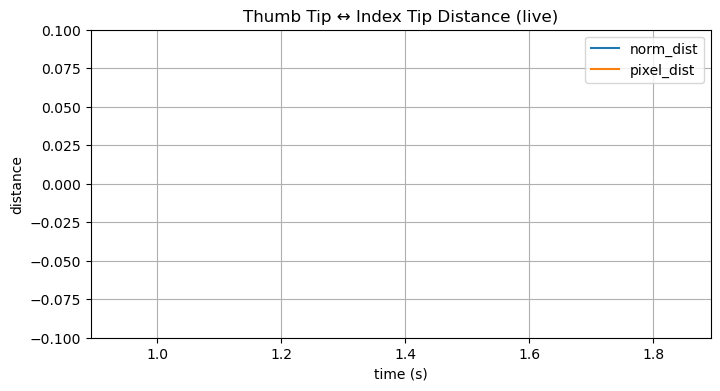

[15:35:34] no hand
[15:35:35] no hand
[15:35:37] norm=0.2356  pix=112.8px  pinch=no
[15:35:41] norm=0.2606  pix=125.0px  pinch=no
[15:35:42] norm=0.3554  pix=171.2px  pinch=no
[15:35:43] norm=0.1129  pix=54.1px  pinch=no
[15:35:45] norm=0.2517  pix=122.1px  pinch=no
[15:35:46] norm=0.2472  pix=120.9px  pinch=no
[15:35:48] norm=0.2336  pix=114.8px  pinch=no
[15:35:49] norm=0.1368  pix=66.3px  pinch=no
[15:35:51] norm=0.1163  pix=55.3px  pinch=no
[15:35:52] norm=0.1649  pix=82.5px  pinch=no
[15:35:54] norm=0.3156  pix=152.8px  pinch=no
[15:35:55] no hand
[15:35:56] no hand
[15:35:58] no hand
[15:35:59] norm=0.2816  pix=143.2px  pinch=no
[15:36:01] norm=0.2239  pix=107.2px  pinch=no
[15:36:02] norm=0.1230  pix=58.1px  pinch=no
[15:36:04] norm=0.2504  pix=120.1px  pinch=no
[15:36:05] norm=0.2544  pix=122.3px  pinch=no
[15:36:07] norm=0.3081  pix=148.3px  pinch=no
[15:36:08] norm=0.2912  pix=140.4px  pinch=no
[15:36:10] norm=0.2635  pix=126.3px  pinch=no
[15:36:11] norm=0.2938  pix=141.4px 

In [19]:
"""
hand_distance_live_plot.py

Real-time hand landmark distance + live plot.

Requirements:
    pip install mediapipe opencv-python matplotlib numpy
"""

import time
import math
from collections import deque
import csv
import os

import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Configuration ----------------
CAM_INDEX = 0
MAX_PTS = 200                 # number of points shown on the live plot (rolling window)
PRINT_EVERY_N_FRAMES = 15     # console print frequency
PINCH_PIXEL_THRESHOLD = 40
PINCH_NORM_THRESHOLD = 0.03

LOG_TO_CSV = True             # toggle CSV logging
CSV_FILENAME = "hand_distance_log.csv"
# ------------------------------------------------

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    max_num_hands=2
)

# Initialize webcam
cap = cv2.VideoCapture(CAM_INDEX)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open camera index {CAM_INDEX}")

# Prepare data structures for live plotting
timestamps = deque(maxlen=MAX_PTS)
norm_dists = deque(maxlen=MAX_PTS)
pixel_dists = deque(maxlen=MAX_PTS)

# Prepare matplotlib figure
plt.ion()
fig, ax = plt.subplots(figsize=(8, 4))
line_norm, = ax.plot([], [], label="norm_dist")   # do not set colors explicitly
line_pix, = ax.plot([], [], label="pixel_dist")
ax.set_xlabel("time (s)")
ax.set_ylabel("distance")
ax.set_title("Thumb Tip ↔ Index Tip Distance (live)")
ax.legend(loc="upper right")
ax.grid(True)

start_time = time.time()
frame_count = 0

# Prepare CSV log
if LOG_TO_CSV:
    first_write = not os.path.exists(CSV_FILENAME)
    csv_file = open(CSV_FILENAME, "a", newline="")
    csv_writer = csv.writer(csv_file)
    if first_write:
        csv_writer.writerow(["timestamp_iso", "elapsed_s", "norm_dist", "pixel_dist", "pinch"])

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to read frame from camera. Exiting.")
            break

        frame = cv2.flip(frame, 1)
        img_h, img_w = frame.shape[:2]
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)

        norm_dist = None
        pixel_dist = None
        pinch = False
        handedness_label = None

        if results.multi_hand_landmarks and len(results.multi_hand_landmarks) > 0:
            # use first detected hand (index 0)
            hand_landmarks = results.multi_hand_landmarks[0]
            lm_thumb = hand_landmarks.landmark[4]
            lm_index = hand_landmarks.landmark[8]

            dx_n = lm_thumb.x - lm_index.x
            dy_n = lm_thumb.y - lm_index.y
            dz_n = lm_thumb.z - lm_index.z
            norm_dist = math.sqrt(dx_n*dx_n + dy_n*dy_n + dz_n*dz_n)

            tx_px = int(round(lm_thumb.x * img_w))
            ty_px = int(round(lm_thumb.y * img_h))
            ix_px = int(round(lm_index.x * img_w))
            iy_px = int(round(lm_index.y * img_h))
            pixel_dist = math.hypot(tx_px - ix_px, ty_px - iy_px)

            if pixel_dist <= PINCH_PIXEL_THRESHOLD or (norm_dist is not None and norm_dist <= PINCH_NORM_THRESHOLD):
                pinch = True

            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            cv2.circle(frame, (tx_px, ty_px), 8, (0, 0, 255), -1)
            cv2.circle(frame, (ix_px, iy_px), 8, (255, 0, 0), -1)
            cv2.line(frame, (tx_px, ty_px), (ix_px, iy_px), (0, 255, 0), 2)

            if results.multi_handedness and len(results.multi_handedness) > 0:
                try:
                    handedness_label = results.multi_handedness[0].classification[0].label
                except Exception:
                    handedness_label = None

        # overlay text
        base_y = 25
        dy_text = 26
        lines = []
        if handedness_label:
            lines.append(f"Hand: {handedness_label}")
        if norm_dist is not None:
            lines.append(f"Norm: {norm_dist:.4f}")
        if pixel_dist is not None:
            lines.append(f"Pixel: {pixel_dist:.1f}px")
        lines.append(f"Pinch: {'YES' if pinch else 'no'}")

        for i, txt in enumerate(lines):
            cv2.putText(frame, txt, (10, base_y + i*dy_text), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

        cv2.imshow("Hand Distance (press 'q' to quit)", frame)

        # update data buffers
        elapsed = time.time() - start_time
        timestamps.append(elapsed)
        norm_dists.append(norm_dist if norm_dist is not None else np.nan)
        pixel_dists.append(pixel_dist if pixel_dist is not None else np.nan)

        # update plot lines (convert deques to arrays)
        t_arr = np.array(timestamps)
        norm_arr = np.array(norm_dists)
        pix_arr = np.array(pixel_dists)

        # keep x axis relative to current time window
        if len(t_arr) > 0:
            xmin = t_arr[0]
            xmax = t_arr[-1]
            ax.set_xlim(xmin, xmax if xmax > xmin else xmin + 1)

        # scale pixel distances to overlay with normalized values on same axis for visibility:
        # compute scale factor only when we have values
        if np.nanmax(pix_arr) > 0 and np.nanmax(norm_arr) > 0:
            # map pixel max to ~ (norm max * factor)
            # choose factor so both series are visible; if pixel magnitudes are large, downscale them
            # simple heuristic:
            factor = (np.nanmax(norm_arr) + 1e-6) / (np.nanmax(pix_arr) + 1e-6)
        else:
            factor = 1.0

        scaled_pix = pix_arr * factor

        # update plotted data
        line_norm.set_data(t_arr, norm_arr)
        line_pix.set_data(t_arr, scaled_pix)

        # recompute y-limits to fit data
        y_vals = np.concatenate([np.nan_to_num(norm_arr, nan=0.0), np.nan_to_num(scaled_pix, nan=0.0)])
        if y_vals.size > 0:
            y_min, y_max = np.min(y_vals), np.max(y_vals)
            padding = (y_max - y_min) * 0.1 if (y_max - y_min) > 0 else 0.1
            ax.set_ylim(y_min - padding, y_max + padding)

        ax.relim()
        ax.autoscale_view()  # ensure view updated
        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.pause(0.001)  # keep UI responsive

        # optional CSV logging
        if LOG_TO_CSV:
            iso_ts = time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime())
            csv_writer.writerow([
                iso_ts,
                f"{elapsed:.3f}",
                f"{(norm_dist if norm_dist is not None else '')}",
                f"{(pixel_dist if pixel_dist is not None else '')}",
                "1" if pinch else "0"
            ])
            # flush file occasionally
            if frame_count % 50 == 0:
                csv_file.flush()

        # occasional console print
        if frame_count % PRINT_EVERY_N_FRAMES == 0:
            now = time.strftime("%H:%M:%S")
            if norm_dist is None:
                print(f"[{now}] no hand")
            else:
                print(f"[{now}] norm={norm_dist:.4f}  pix={pixel_dist:.1f}px  pinch={'YES' if pinch else 'no'}")

        frame_count += 1

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    cap.release()
    cv2.destroyAllWindows()
    hands.close()
    if LOG_TO_CSV:
        csv_file.close()
    print("Clean exit.")

In [20]:
!pip install streamlit pandas

   ---------------------------------------- 0.0/10.2 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/10.2 MB 6.1 MB/s eta 0:00:02
   ---------- ----------------------------- 2.6/10.2 MB 6.6 MB/s eta 0:00:02
   --------------- ------------------------ 3.9/10.2 MB 6.2 MB/s eta 0:00:02
   -------------------- ------------------- 5.2/10.2 MB 6.5 MB/s eta 0:00:01
   ----------------------- ---------------- 6.0/10.2 MB 6.1 MB/s eta 0:00:01
   ------------------------- -------------- 6.6/10.2 MB 5.3 MB/s eta 0:00:01
   --------------------------- ------------ 7.1/10.2 MB 4.8 MB/s eta 0:00:01
   ----------------------------- ---------- 7.6/10.2 MB 4.4 MB/s eta 0:00:01
   ------------------------------- -------- 8.1/10.2 MB 4.3 MB/s eta 0:00:01
   -------------------------------- ------- 8.4/10.2 MB 4.3 MB/s eta 0:00:01
   ---------------------------------- ----- 8.7/10.2 MB 3.9 MB/s eta 0:00:01
   ------------------------------------ --- 9.2/10.2 MB 3.6 MB/s eta 0:00:01
   ---